# Medición de diámetros a partir de una imagen patrón

In [ ]:
%pip install scikit-learn
%pip install opencv-python
%pip install numba
%pip install tk
%pip install ipympl
%pip install metas_unclib

In [1]:
from functions import *     # Funciones definidas en functions.py (Para VS Code agregar dir. en carpeta AppData, settings.json)
import cv2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider
%matplotlib inline
from metas_unclib import *  # Requiere la librería de C# METAS UncLib en segundo plano
use_linprop()
from tkinter import Tk  
from tkinter.filedialog import askopenfilename

## Preparación de archivos

In [4]:
DIR = "C:\\Users\\Admin\\Documents\\SEM Lineas de Aire\\Mediciones" # Directorio base para varias imágenes

ENDEREZAR = True   # True para enderezar las imágenes

CANNY = 0   # Método de Umbral (Cruce en medio del flanco)
THRESHOLD = 1   # Método de Umbral (Cruce en medio del flanco)
KNEE = 2    # Método de Knee (Detección al inicio del flanco)

METODO = CANNY
MANUAL = False

Ventana para seleccionar archivos

In [8]:
root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)

path_patron = askopenfilename(filetypes=[("Archivo TIF", "*.tif"), ("Archivo BMP", "*.bmp"), ("All files", "*.*")], title='Seleccione Patrón', initialdir=DIR)
path_dut = askopenfilename(filetypes=[("Archivo TIF", "*.tif"), ("Archivo BMP", "*.bmp"), ("All files", "*.*")], title='Seleccione DUT', initialdir=DIR)

if path_patron.endswith('.ufloat'): # Carga valores ya calculados
    peso_pixel = ustorage.load_binary_file(path_patron)
    print("Peso pixel (patrón) cargado")
    calcular_patron = False
else:
    calcular_patron = True

Comprobar las imágenes de entrada

In [11]:
SCALE = 15  # Factor de escala para visualización

# ------------ Patron ------------
if calcular_patron:
    patron = read_image(path_patron, eigth_bits=True)
    
    patron = delete_bottom(patron, 320)
    # patron = delete_left(patron, 10)
    # patron = delete_right(patron, 10)
    show_image(patron, SCALE)

# ------------ DUT ------------
dut = read_image(path_dut, eigth_bits=True)
dut = delete_bottom(dut, 330)
# dut = delete_left(dut, 500)
# dut = delete_right(dut, 250)
show_image(dut, SCALE)

## Definir los parámetros de detección

Para definir los hiperparámetros manualmente se utiliza la clase DefineThreshold. 

In [12]:
if MANUAL:
    if METODO==CANNY:
        # Otros parámetros a definir (ver función Canny_Edges)
        bs = 3          # blur_size
        l2g = False     # L2gradient
        if calcular_patron:
            dt1 = DefineThreshold(patron, Canny_Edges, two_params=True)
            th1_pat, th2_pat = dt1.get_th(blur_size = bs, L2gradient = l2g)
        dt1 = DefineThreshold(dut, Canny_Edges, two_params=True)
        th1_dut, th2_dut = dt1.get_th(blur_size = bs, L2gradient = l2g)

    elif METODO==THRESHOLD:
        if calcular_patron:
            dt1 = DefineThreshold(patron, Thresholding, two_params=False)
            th1_pat, th2_pat = dt1.get_th()
        dt1 = DefineThreshold(dut, Thresholding, two_params=False)
        th1_dut, th2_dut = dt1.get_th()

    elif METODO==KNEE:  # Técnicamente no se define un umbral sino un entorno de detección (N)
        if calcular_patron:
            dt1 = DefineThreshold(patron, Knee_Detection, two_params=False, th_max=50)
            N_pat, _ = dt1.get_th()
        dt1 = DefineThreshold(dut, Knee_Detection, two_params=False, th_max=50)
        N_dut, _ = dt1.get_th()
else:
    # Se definen valores fijos que normalmente funcionan
    N_dut = 15  
    N_pat = 15
    th1_dut, th2_dut = (dut.max()//2, dut.max)      # Borde en medio
    th1_pat, th2_pat = (patron.max()//2, patron.max)

    if METODO==CANNY:
        edges1 = Canny_Edges(dut, th1_dut, th2_dut, False, 3)    #Deteccion de bordes
        if calcular_patron:
            edges2 = Canny_Edges(patron, th1_pat, th2_pat, False, 3)    #Deteccion de bordes
    elif METODO==THRESHOLD:
        edges1 = Thresholding(dut, th1_dut, th2_dut)
        if calcular_patron:
            edges2 = Thresholding(patron, th1_pat, th2_pat)
    else:
        edges1 = Knee_Detection(dut, N_dut)
        if calcular_patron:
            edges2 = Knee_Detection(patron, N_pat)

error: OpenCV(4.8.1) :-1: error: (-5:Bad argument) in function 'Canny'
> Overload resolution failed:
>  - Argument 'threshold2' can not be treated as a double
>  - Argument 'threshold2' can not be treated as a double
>  - Canny() missing required argument 'threshold2' (pos 4)
>  - Canny() missing required argument 'threshold2' (pos 4)


Comprobar la ubicación de los bordes en cada fila

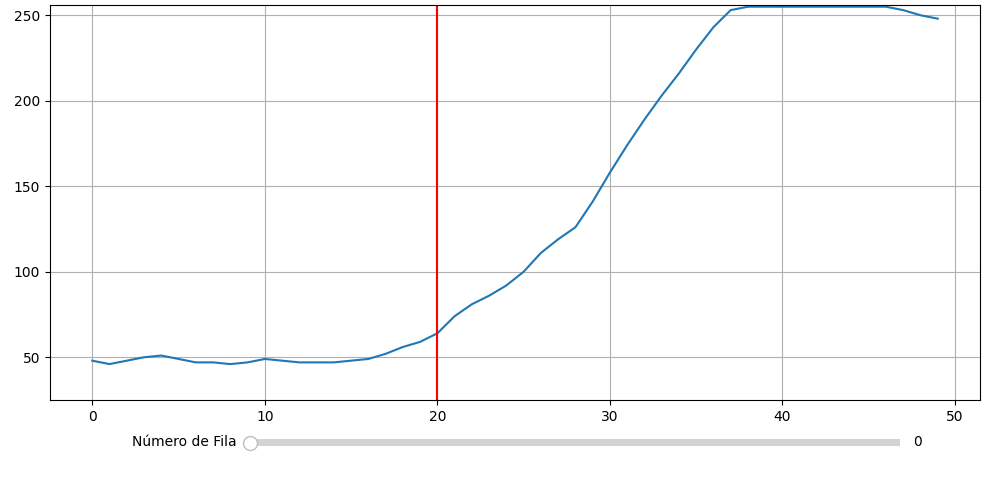

In [10]:
ev1 = EdgesViewer(dut, edges1, first_edge=True, N_points=50)
%matplotlib widget
ev1.plot()

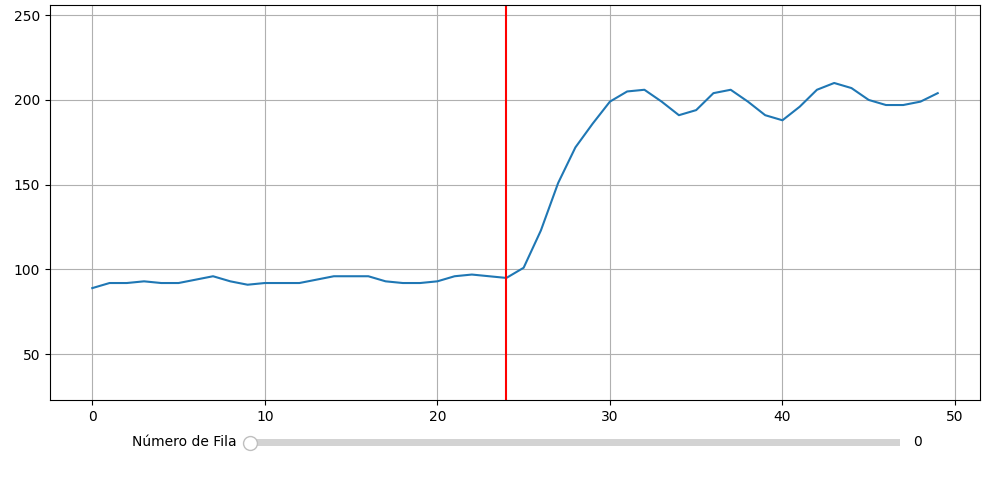

In [11]:
if calcular_patron:
    ev2 = EdgesViewer(patron, edges2, first_edge=True)
    %matplotlib widget
    ev2.plot()

In [12]:
# ----------- Volver a modo Inline ------------
plt.close('all')
%matplotlib inline

Guardar Imagenes de Bordes

In [16]:
save_img(edges1, path_dut, legend="bordes")
if calcular_patron:
    save_img(edges2, path_patron, legend="bordes")

## Enderezamiento y medición

Utiliza uno de los métodos de deteccion y optimiza el ángulo de rotación (si ENDEREZAR = True). Siempre verificar la imagen de salida!

Posibles parámetros para elegir el angulo de rotación: 
- Tomar las distancias globalmente, cuando su media o su desvío sean mínimos.
- Agrupar los primeros y últimos pixeles, cuando el desvío de cada grupo sea menor.

Se encontraron mejores resultados con el segundo método, que es el que se incluye.

### PATRÓN

Desvío primer pixel (px)
Mejor angulo medido: -0.857°
Mejor angulo ajustado: 0.093°. Score=0.581

Desvío último pixel (px)
Mejor angulo medido: -1.714°
Mejor angulo ajustado: -1.548°. Score=0.431

Ajuste entre ambos lados: -0.606 °


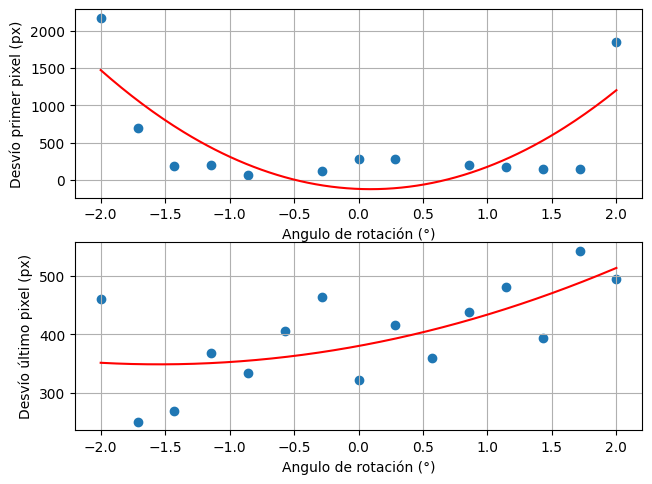

In [13]:
# Generar vector de grados, si el mínimo de la curva se encuentra
# muy desplazado, volver a generarlo teniendo eso en cuenta.
grados = np.linspace(-2, 2, 15) 

if calcular_patron:
    if ENDEREZAR:
        if METODO==CANNY:
            angulo_elegido = align(patron, grados, Canny_Edges, th1=th1_pat, th2=th2_pat, L2gradient=l2g, blur_size=bs)
        elif METODO==THRESHOLD:
            angulo_elegido = align(patron, grados, Thresholding, thresh=th1_pat, max_val=th2_pat)
        elif METODO==KNEE:
            angulo_elegido = align(patron, grados, Knee_Detection, N=N_pat)
    else:
        angulo_elegido = 0

Medición final con ángulo elegido

In [15]:
# Correccion a mano
angulo_elegido = 0.2

Media inicial: 5554.775540275049
Moda: 5608
Media final: 5611.141710559318



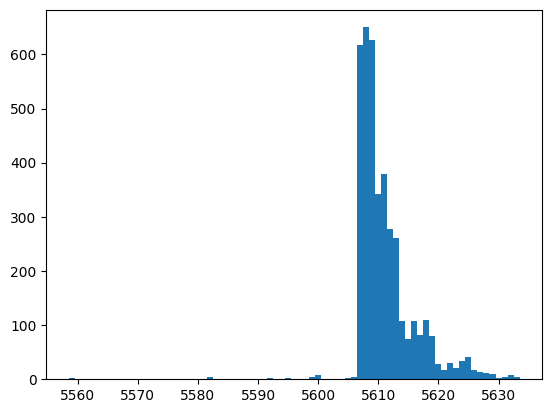

3987 filas con media 5611.141710559318 (0.07856759369506265) px



In [16]:
if calcular_patron:
    img = rotate_and_cut(patron, angulo_elegido)  # Rota la imagen g grados según lo ajustado
    if METODO==CANNY:
        edges = Canny_Edges(img, th1_pat, th2_pat)    #Deteccion de bordes
    elif METODO==THRESHOLD:
        edges = Thresholding(img, th1_pat, th2_pat)
    elif METODO==KNEE:
        edges = Knee_Detection(img, N_pat)
    show_image(edges, SCALE)
    # cv2.imwrite(DIR + "Pat_Edges.bmp", edges)
    diams1 = direct_distance(edges, outlier_percent=1, plot=True)   #Mide distancias entre bordes
    mean_patron, u_patron = measure_distribution(diams1)   #Guarda las medias y desvios

### DUT

Desvío primer pixel (px)
Mejor angulo medido: 1.286°
Mejor angulo ajustado: -0.002°. Score=0.571

Desvío último pixel (px)
Mejor angulo medido: -1.286°
Mejor angulo ajustado: -3.0°. Score=0.099

Ajuste entre ambos lados: -0.445 °


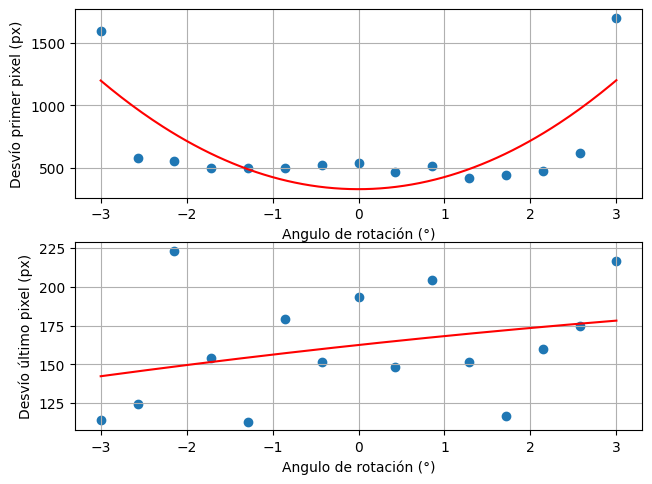

In [18]:
# Generar vector de grados, si el mínimo de la curva se encuentra
# muy desplazado, volver a generarlo teniendo eso en cuenta.
grados = np.linspace(-3, 3, 15) 

if ENDEREZAR:
    if METODO==CANNY:
        angulo_elegido = align(dut, grados, Canny_Edges, th1=th1_dut, th2=th2_dut, L2gradient=l2g, blur_size=bs)
    elif METODO==THRESHOLD:
        angulo_elegido = align(dut, grados, Thresholding, thresh=th1_dut, max_val=th2_dut)
    elif METODO==KNEE:
        angulo_elegido = align(dut, grados, Knee_Detection, N=N_dut)
else:
    angulo_elegido = 0

In [48]:
#Ajuste a mano
angulo_elegido = -0.5

Medición final con ángulo elegido

Media inicial: 4392.441969809453
Moda: 4444
Media final: 4450.986934673367



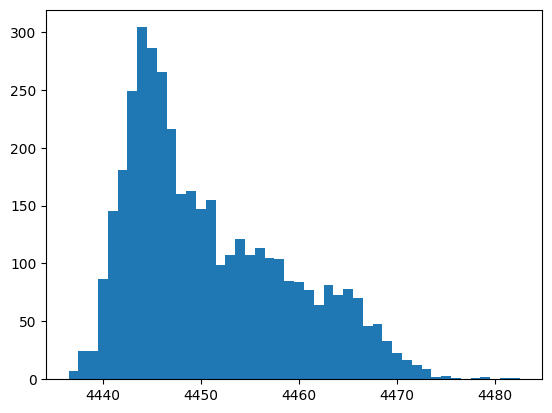

3980 filas con media 4450.986934673367 (0.1301777490394561) px



In [19]:
img = rotate_and_cut(dut, angulo_elegido)  # Rota la imagen g grados según lo ajustado
if METODO==CANNY:
    edges = Canny_Edges(img, th1_dut, th2_dut, l2g, bs)    #Deteccion de bordes
elif METODO==THRESHOLD:
    edges = Thresholding(img, th1_dut, th2_dut)
elif METODO==KNEE:
    edges = Knee_Detection(img, N_dut)
# cv2.imwrite(DIR + "DUT_Edges.bmp", edges)
show_image(edges, SCALE)
diams1 = direct_distance(edges, outlier_percent=1, plot=True)   #Mide distancias entre bordes
mean_dut, u_dut = measure_distribution(diams1)   #Guarda las medias y desvios

## Cálculo

In [20]:
# ---------------- Parámetros -----------------

DIAMETRO_PATRON = 1500 # diámetro medido del patrón (micrómetros)
INCERTIDUMBRE_PATRON = 0.023 # incert. patrón

diam_patron = ufloat(DIAMETRO_PATRON, INCERTIDUMBRE_PATRON, id='1', desc="Magnitud del Patrón")
media_patron = ufloat(mean_patron, u_patron, id='2', desc="Media de pixeles del patrón")

peso_pixel = diam_patron/media_patron

In [21]:
media_dut = ufloat(mean_dut, u_dut, id='3', desc="Media de pixeles del DUT")
result = peso_pixel * media_dut

print("Peso de 1 pixel:", peso_pixel, "um")
print(f"El diametro resultante es de {result} micrometros")

Peso de 1 pixel: 0.2673252748504333 ± 3.558805897509858e-07 um
El diametro resultante es de 1189.8613056672452 ± 0.03638382239666881 micrometros


## Guardado

In [27]:
ustorage.save_binary_file(peso_pixel, DIR + "\\peso_pixel_1_5.ufloat")
ustorage.save_binary_file(result, DIR + "\\diametro_linea_1_27.ufloat")